In [61]:
import os
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import pickle
import numpy as np
from tqdm import tqdm
import shapely
from PIL import Image
from skimage.morphology import skeletonize
from collections import deque
from scipy import stats

In [2]:
import torch
from transformers import SamModel, SamProcessor

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

In [3]:
def cm_dce(ground_truth_masks,predicted_masks):
    
    num_rows = ground_truth_masks.shape[0]
    num_columns = predicted_masks.shape[0]
    
    cm_matrix_dice = np.zeros((num_rows,num_columns))
    
    for r in tqdm(range(num_rows)):
        
        for c in range(num_columns):
            
            cm_matrix_dice[r][c] = dce(ground_truth_masks[r],predicted_masks[c])
            
    return cm_matrix_dice

In [4]:
def get_labels(center_pts,height,width):
    
    #first find neighbours
    #here the centers are appened as [x,y] not [r,c]
    val_cent = {}
    val_neighbour = {}
    
    iterator = np.zeros((height,width))

    for count,crop in enumerate(center_pts):
        row = crop[1]
        column = crop[0]
        iterator[crop[1],crop[0]] = count+1
    que = deque([])
    for r in range(height):
        for c in range(width):

            if(iterator[r][c]!=0):
                que.append([c,r])
                val_cent[iterator[r][c]] = [c,r]
                val_neighbour[iterator[r][c]] = set()
                
                
    #dirs = [[0,1],[0,-1],[1,0],[-1,0],[1,1],[-1,-1],[1,-1],[-1,1]]
    dirs = [[0,1],[0,-1],[1,0],[-1,0]]
    
    while(len(que)!=0):
        c,r = que.popleft()
        val = iterator[r][c]
        for i,j in dirs:
            k = r+i
            l = c+j
            if(k>=0 and k<height and l>=0 and l<width):
                if(iterator[k][l] == 0):
                    iterator[k][l] = val
                    que.append([l,k])
                elif(iterator[k][l]!=val):
                    if iterator[k][l] not in val_neighbour[val]:
                        val_neighbour[val].add(iterator[k][l])
    
    #find labels for the adjacent neighbours
    
    input_cents = []
    cent_labels = []
    for key in val_neighbour.keys():
        lab = [1] #adding the centroid  for label 1. positive label
        cent = [val_cent[key]] #adding the centroids for negative label with pos 0
        for value in val_neighbour[key]:
            cent.append(val_cent[value])
            lab.append(0)
        input_cents.append(cent)
        cent_labels.append(lab)
        
    return input_cents,cent_labels,val_cent,val_neighbour,iterator

In [5]:
def show_pos_neg_points_single_image(raw_image,input_points,input_labels = None):
    
    fig,axes = plt.subplots(1,2,figsize = (10,10))
    axes[0].imshow(raw_image)
    input_points = np.array(input_points)
    
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    
    show_points(input_points, labels, axes[0])
    axes[1].imshow(raw_image)
    plt.show()

In [6]:
def get_grain_center(grain):
    centy = 0
    centx = 0
    for x,y in grain:
        centy = centy + y
        centx = centx + x

    sz = len(grain)
    centy = int(centy/sz)
    centx = int(centx/sz)
    return centx,centy

In [7]:
def get_annot_mask(bound,centy,centx):
    
    
    dirs = [[0,1],[0,-1],[1,0],[-1,0]]
    m,n = bound.shape
    
    que_mask = deque([])
    que_mask.append([centy,centx])
    
    while(len(que_mask)!=0):
    #print(len(que_mask))
        y,x = que_mask.popleft()
    #print(y,x)
    #gg_mask_closed[y][x] = gg_mask[y][x]
        for i,j in dirs:
            k = y+i
            l = x+j
            if(k>=0 and k<m and l>=0 and l<n and bound[k][l] == 0 ):
                bound[k][l] = 1
                #print(k,l)
                que_mask.append([k,l])
    
    return bound

In [8]:
def get_mask_from_encord(annot_img):
    
    width,height = img.size
    nums = len(annot_img)
    mask_img = np.zeros((nums,height,width))
    
    #getting boundaries.

    for k,grain in tqdm(enumerate(annot_img)):
        bound = np.zeros((height,width))
        centx,centy = get_grain_center(grain)
        #print(centy,centx)
        bound[centy,centx] = 1
        for i in range(len(grain)):

            x0,y0 = grain[i]
            if(i == len(grain)-1):
                x1,y1 = grain[0]
            else:
                x1,y1 = grain[i+1]
            bound = plotLine(x0-1,y0-1,x1-1,y1-1,bound)
            #print(temp.shape)
        
        #plt.imshow(bound)
        #plt.xlim([50,200])
        #plt.ylim([0,100])
        mask_img[k] = get_annot_mask(bound,centy,centx)
        #mask_img[k] = bound
        #print(np.sum(bound))
        #plt.imshow(mask_img[k])
        
        #if(k==2):
            #break
    
    return mask_img

In [9]:
def join_boundaries(some_img):
    kernel = np.ones((5,5),np.uint8)
    some_img = cv2.dilate(some_img,kernel,iterations = 2)
    skeleton = skeletonize(some_img) 
    return skeleton

In [10]:
def mask_to_bound(some_mask):
    kernel = np.ones((3,3),np.uint8)
    dilated_mask = cv2.dilate(some_mask,kernel,iterations = 1)
    bound_mask = cv2.subtract(dilated_mask,some_mask)
    return bound_mask

In [11]:
def get_centroid(bin_img):
    
    m00 = np.sum(bin_img)
    m10 = np.sum(np.arange(bin_img.shape[0])[:,np.newaxis]* bin_img)
    m01 = np.sum(np.arange(bin_img.shape[1])[np.newaxis,:]*bin_img)
    
    cent_y = int(m10/m00)
    cent_x = int(m01/m00)
    
    return cent_y,cent_x

In [12]:
def get_mask_closed_filled(gg_mask):
    
    
    dirs = [[0,1],[0,-1],[1,0],[-1,0],[1,1],[-1,-1],[1,-1],[-1,1]]
    gg_mask_y,gg_mask_x = get_centroid(gg_mask)
    gg_mask_closed = np.zeros_like(gg_mask)
    gg_mask_closed[gg_mask_y,gg_mask_x] = gg_mask[gg_mask_y,gg_mask_x]
    m,n = gg_mask.shape
    
    que_mask = deque([])
    que_mask.append([gg_mask_y,gg_mask_x])
    
    while(len(que_mask)!=0):
    #print(len(que_mask))
        y,x = que_mask.popleft()
    #print(y,x)
    #gg_mask_closed[y][x] = gg_mask[y][x]
        for i,j in dirs:
            k = y+i
            l = x+j
            if(k>=0 and k<m and l>=0 and l<n and gg_mask[k][l] == 1 and gg_mask_closed[k][l] == 0):
                gg_mask_closed[k][l] = gg_mask[k][l]
                #print(k,l)
                que_mask.append([k,l])
    
    gg_mask_closed = np.array(gg_mask_closed,np.uint8)
    dil_kernel = np.ones((5,5),np.uint8)
    gg_mask_closed = cv2.dilate(gg_mask_closed,dil_kernel,iterations = 2)
    gg_mask_closed = cv2.erode(gg_mask_closed,dil_kernel,iterations = 2)
    
    return gg_mask_closed

In [13]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [14]:
def show_masks_on_image_2(raw_image,masks):
    if len(masks.shape) == 4:
      masks = masks.squeeze()

    fig,axes = plt.subplots(1,2,figsize = (12,12))
    axes[0].imshow(raw_image)
    axes[1].imshow(raw_image)
    print(masks.shape)
    for mask in masks:
        if torch.is_tensor(mask):
            mask = mask.cpu().detach()
        show_mask(mask,axes[1],True)
    plt.show()

In [15]:
def show_points(coords, labels, ax, marker_size=100):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

In [16]:
def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    #print(input_points[:,0].shape)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

In [17]:
def dce(ground_truth,prediction):
    ground_truth = np.array(ground_truth,np.uint8)
    predictions = np.array(prediction,np.uint8)
    intersection = np.sum(cv2.bitwise_and(ground_truth,prediction))
    cardinal_sum = np.sum(ground_truth) + np.sum(prediction)
    f1 = 2*intersection/cardinal_sum
    return f1

In [18]:
def plot_polygon_2(pts_list,axis):
    polygon_patch = Polygon(pts_list,edgecolor = 'blue',facecolor = 'lightblue', alpha = 0.7)
    axis.add_patch(polygon_patch)

In [19]:
def plotStLine(x0,y0,x1,y1,temp_img):
    
    dx = abs(x1 - x0)
    if(x0<x1):
        sx=1
    else:
        sx = -1
        
    if(y0<y1):
        sy=1
    else:
        sy = -1
    
    dy = -abs(y1-y0)
    
    error = dy + dx
    
    while True:
        temp_img[y0][x0] = 1
        if(x0 == 0 and y0 == y1):
            break
        e2 = 2 * error
        
        if e2>=dy:
            if x0 == x1:
                break
            error = error + dy
            x0 = x0 + sx
        
        if e2<=dx:
            
            if y0 == y1:
                break
            error = error + dx
            y0 = y0 + sy
    
    return temp_img

In [20]:
def plotLineLow(x0,y0,x1,y1,temp_img):
    
    dx = x1 - x0
    dy = y1 - y0
    yi = 1
    if dy<0:
        yi = -1
        dy = -dy
    D = 2*dy - dx
    y = y0
    
    for x in range(x0,x1):
        
        temp_img[y][x] = 1
        if D>0:
            
            y = y+yi
            D = D + (2*(dy-dx))
        else:
            D = D + 2*dy
    
    return temp_img

In [21]:
def plotLineHigh(x0,y0,x1,y1,temp_img):
    
    dx = x1 - x0
    dy = y1 - y0
    xi = 1
    
    if dx<0:
        
        xi = -1
        dx = -dx
    
    D = 2*dx - dy
    x = x0
    
    for y in range(y0,y1):
        
        temp_img[y][x] = 1
        if D>0:
            x = x +xi
            D = D + (2*(dx - dy))
        else:
            D = D + 2*dx
    
    return temp_img

In [22]:
def plotLine(x0,y0,x1,y1,temp_img):
    
    #for encord thats why subtracting from 1 to remove the bias
    
    x0 = int(x0)
    y0 = int(y0)
    x1 = int(x1)
    y1 = int(y1)
    temp_img[y0][x0] = 1
    temp_img[y1][x1] = 1
    
    if (x0 == x1 or y0 == y1): return plotStLine(x0,y0,x1,y1,temp_img)
    
    if abs(y1-y0) < abs(x1-x0):
        if x0>x1:
            return plotLineLow(x1,y1,x0,y0,temp_img)
        else:
            return plotLineLow(x0,y0,x1,y1,temp_img)
    else:
        if y0 > y1:
            return plotLineHigh(x1,y1,x0,y0,temp_img)
        else:
            return plotLineHigh(x0,y0,x1,y1,temp_img)
        
    return temp_img

In [23]:
### getting the ground truth and the ground image
cmap = 'Greys'

In [24]:
curr_dir = os.getcwd()
img_file = os.path.join(curr_dir,'cropped750.jpg')
#img = cv2.transpose(cv2.imread(img_file))
#img = cv2.imread(img_file)
img  = Image.open(img_file).convert('RGB')#.transpose(PIL.Image.TRANSPOSE)
annotations_file = os.path.join(curr_dir,'gb_cropped750_polygons')
with open(annotations_file,"rb") as fp:
    annot_img = pickle.load(fp)

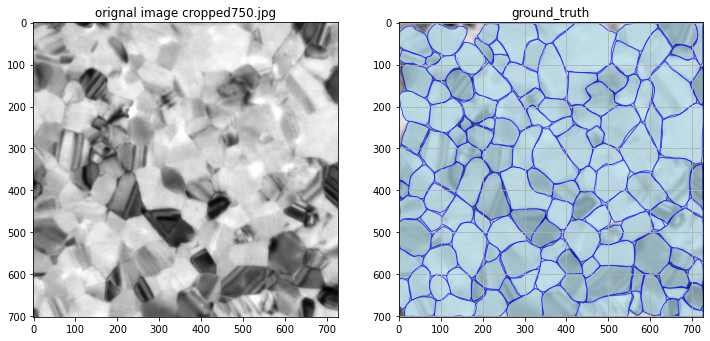

In [25]:
fig,axs = plt.subplots(1,2,figsize = (12,12))
axs[0].imshow(img)
axs[0].set_title('orignal image cropped750.jpg')
axs[1].imshow(img)
axs[1].set_title('ground_truth')
axs[1].set_aspect('equal',adjustable = 'box')
plt.grid(True)
for grains in annot_img:
    #print(grains)
    #print(grains.shape)
    plot_polygon_2(np.array(grains),axs[1])

In [30]:
width,height = img.size
temp_img = np.zeros((height,width))

for grain in tqdm(annot_img):
    grain = shapely.Polygon(grain)
    gg_cords = list(grain.exterior.coords)


    for i in range(len(gg_cords)-1):

        x0,y0 = gg_cords[i]
        x1,y1 = gg_cords[i+1]
        temp_img = plotLine(x0-1,y0-1,x1-1,y1-1,temp_img)

100%|██████████| 133/133 [00:00<00:00, 4751.96it/s]


Text(0.5, 1.0, 'ground truth mask to compare')

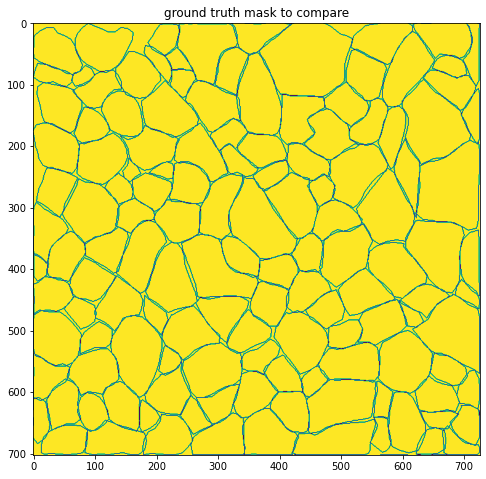

In [31]:
fig = plt.figure(figsize = (8,8))
temp_img = np.array(temp_img,np.uint8)
plt.imshow(np.invert(temp_img))
plt.title('ground truth mask to compare')

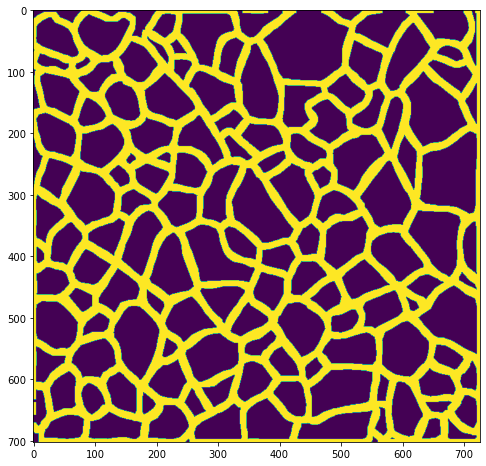

In [32]:
kernel = np.ones((5,5),np.uint8)
temp_img_2 = cv2.dilate(temp_img,kernel,iterations = 2)
#temp_img_2 = cv2.erode(temp_img_2,kernel,iterations = 2)
fig = plt.figure(figsize = (8,8))
plt.imshow(temp_img_2)

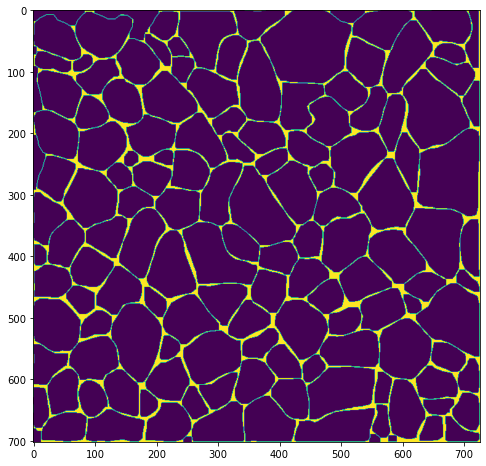

In [33]:
kernel = np.ones((5,5),np.uint8)
temp_img_2 = cv2.dilate(temp_img,kernel,iterations = 2)
temp_img_2 = cv2.erode(temp_img_2,kernel,iterations = 2)
fig = plt.figure(figsize = (8,8))
plt.imshow(temp_img_2)

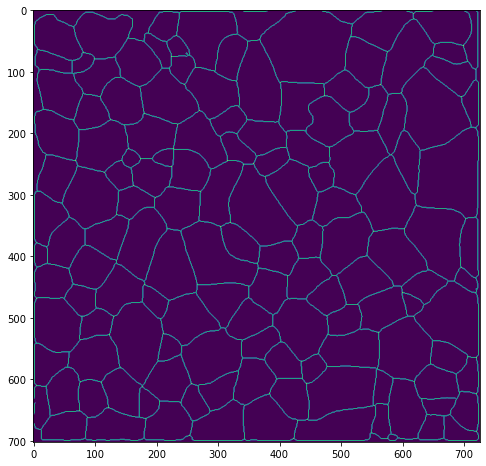

In [34]:
kernel = np.ones((5,5),np.uint8)
temp_img_2 = cv2.dilate(temp_img,kernel,iterations = 2)
skeleton = skeletonize(temp_img_2)
skeleton = np.array(skeleton,np.uint8)
fig = plt.figure(figsize = (8,8))
plt.imshow(skeleton)

In [35]:
###overlay skeleton over the image to see if the boundaries are not altered much

In [36]:
overlay = np.array(img,np.uint8)
height,width = np.shape(skeleton)
for r in range(height):
    for c in range(width):
        if(skeleton[r][c] == 1):
            overlay[r][c] = [0,0,255]

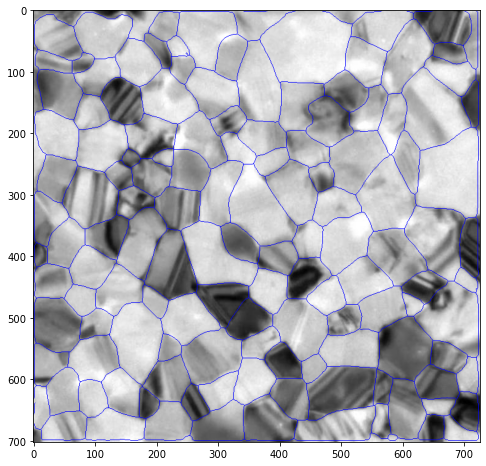

In [37]:
fig = plt.figure(figsize = (8,8))
plt.imshow(overlay)

In [38]:
temp_img.shape

(702, 726)

In [39]:
dce(temp_img[0:height,0:width],skeleton) # low maybe due to multiple boundary converged into one

0.32051000219828535

In [ ]:
### Segments from the SAM with manual point attention

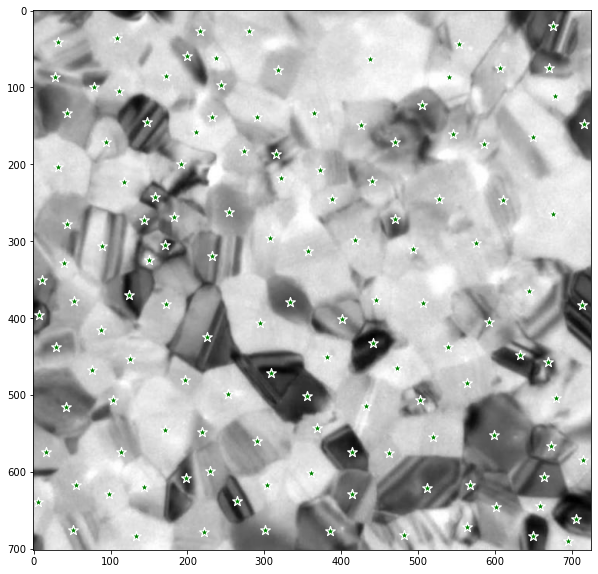

In [26]:
crop_900_pts = np.load('cropped750.npy')
#crop_900_pts[:,[0,1]] = crop_900_pts[:,[1,0]]
crop_900_pts_img = crop_900_pts.tolist()
show_points_on_image(img,crop_900_pts_img) # this is plotted correctly cause the points in the crop900 are x and y

In [90]:
crop_900_pts_token = np.expand_dims(crop_900_pts,axis = 1).tolist()
input_points = [crop_900_pts_token]

inputs = processor(img, input_points=input_points,return_tensors="pt").to(device)
image_embeddings = model.get_image_embeddings(inputs["pixel_values"])

inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs,multimask_output=False)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

torch.Size([132, 702, 726])


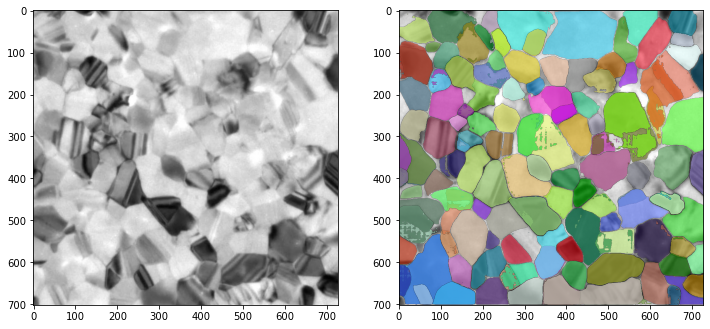

In [91]:
show_masks_on_image_2(img, masks[0])

In [92]:
gg_concat_mask = masks[0].cpu().numpy()
a,b,_,_ = gg_concat_mask.shape
gg_concat_mask_closed = np.zeros_like(gg_concat_mask)
for i in tqdm(range(a)):
    for j in range(b):
        gg_concat_mask_closed[i][j] = get_mask_closed_filled(gg_concat_mask[i][j])

100%|██████████| 132/132 [00:12<00:00, 10.85it/s]


(132, 702, 726)


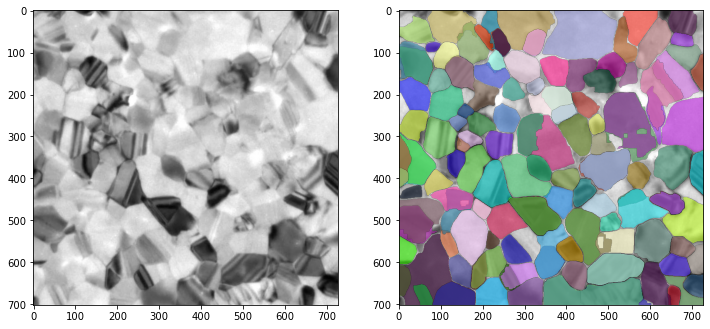

In [93]:
### after filling them and seperating them from unconnected regions
show_masks_on_image_2(img, gg_concat_mask_closed)

In [45]:
closed_mask_boundary = np.zeros((height,width))

In [46]:
gg_concat_mask_closed = np.array(np.squeeze(gg_concat_mask_closed),np.uint8)

In [47]:
closed_mask_boundary = np.zeros((height,width),np.uint8)
for i in range(gg_concat_mask_closed.shape[0]):
    bound_mask = mask_to_bound(gg_concat_mask_closed[i])
    closed_mask_boundary = cv2.bitwise_or(closed_mask_boundary,bound_mask)

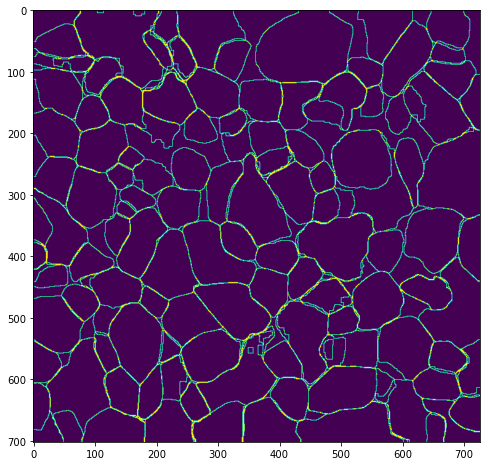

In [48]:
fig = plt.figure(figsize = (8,8))
plt.imshow(closed_mask_boundary)

In [49]:
closed_mask_boundary_skeleton = join_boundaries(closed_mask_boundary)

Text(0.5, 1.0, 'predicted sam mask with closed and filled')

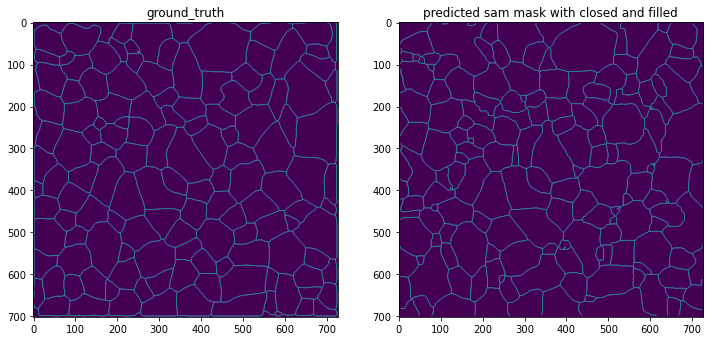

In [50]:
fig,axs = plt.subplots(1,2,figsize = (12,12))
axs[0].imshow(skeleton)
axs[0].set_title('ground_truth')
axs[1].imshow(closed_mask_boundary_skeleton)
axs[1].set_title('predicted sam mask with closed and filled')

In [95]:
skeleton = np.array(skeleton[0:702,0:726],np.uint8)
closed_mask_boundary_skeleton = np.array(closed_mask_boundary,np.uint8)

NameError: name 'skeleton' is not defined

In [52]:
print(dce(skeleton,closed_mask_boundary_skeleton))

0.17141642758474127


In [53]:
#to implement the Dice Matrix score on each grain id between ground truth and predicted ones.
gg_concat_mask_closed.shape

(132, 702, 726)

In [28]:
ground_truth_masks = get_mask_from_encord(annot_img)

133it [00:01, 83.81it/s]


In [55]:
ground_truth_masks.shape

(133, 702, 726)

In [56]:
img.size

(726, 702)

(133, 702, 726)


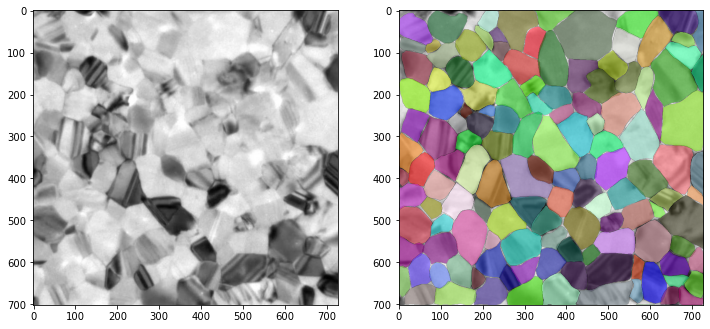

In [57]:
show_masks_on_image_2(img,ground_truth_masks)

(132, 702, 726)


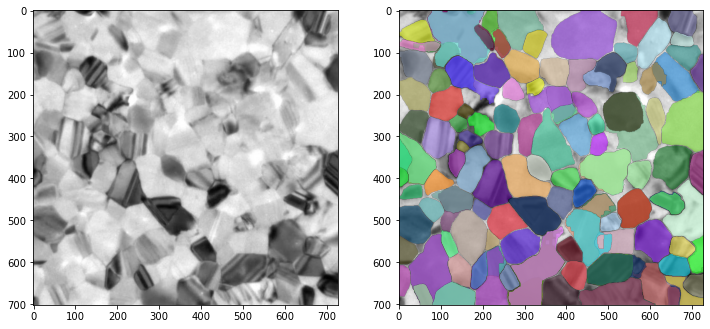

In [58]:
show_masks_on_image_2(img, gg_concat_mask_closed)

### For the mask generated and closed and filled using custom algorithm

In [99]:
gg_concat_mask_closed = np.squeeze(gg_concat_mask_closed)
gg_concat_mask_closed = np.array(gg_concat_mask_closed,np.uint8)

100%|██████████| 133/133 [00:27<00:00,  4.92it/s]

0.7516224377679998


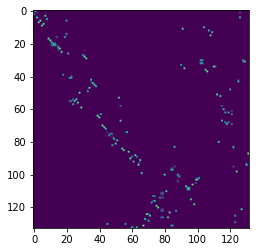

In [100]:
cm_dce_pos_mask_closed = cm_dce(ground_truth_masks,gg_concat_mask_closed)
plt.imshow(cm_dce_pos_mask_closed)
mean_dice = np.average(np.max(cm_dce_pos_mask_closed,axis = 1))
print(mean_dice)

(array([ 3.,  1.,  6.,  6.,  1.,  8., 17., 13., 34., 44.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

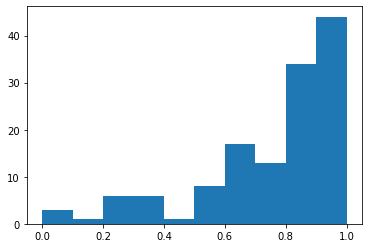

In [101]:
plt.hist(np.max(cm_dce_pos_mask_closed,axis = 1),bins = np.arange(0,1.1,0.1))

### Orignal Output from SAM and with manual segment input points

In [102]:
sam_op = np.squeeze(np.array(masks[0].cpu().detach(),np.uint8))

100%|██████████| 133/133 [00:27<00:00,  4.89it/s]

0.7511459936264333


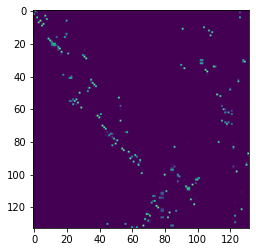

In [103]:
cm_dce_pos_mask = cm_dce(ground_truth_masks,sam_op)
plt.imshow(cm_dce_pos_mask)
mean_dice = np.average(np.max(cm_dce_pos_mask,axis = 1))
print(mean_dice)

(array([ 3.,  1.,  6.,  6.,  1.,  8., 17., 12., 35., 44.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

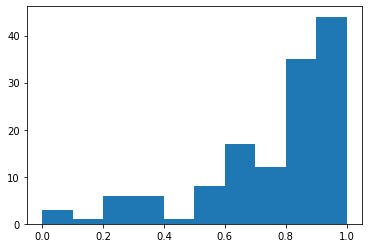

In [105]:
plt.hist(np.max(cm_dce_pos_mask,axis = 1),bins = np.arange(0,1.1,0.1))

### Check for single image with positive and negative labels without mode filter

In [344]:
### write function for calculating neighbours and then finding the labels

In [158]:
img.size

(726, 702)

In [34]:
width,height = img.size
input_cents,cent_labels,val_cent,val_neighbour,iterator = get_labels(crop_900_pts,height,width)

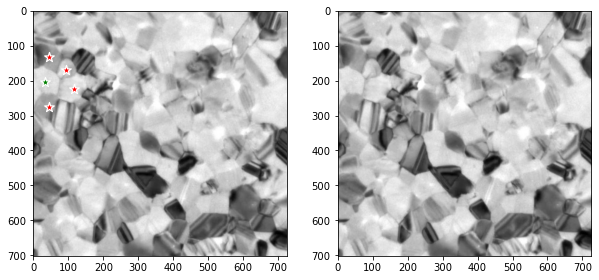

In [35]:
show_pos_neg_points_single_image(img,input_cents[36],cent_labels[36])

In [37]:
mask_2d_with_neg = np.zeros_like(sam_op)
for j,pts,labels in tqdm(zip([k for k in range(len(input_cents))],input_cents,cent_labels)):
        
    input_points = [[pts]]
    input_labels = [[labels]]

    inputs = processor(img, input_points=input_points,input_labels = input_labels,return_tensors="pt").to(device)
    image_embeddings = model.get_image_embeddings(inputs["pixel_values"])

    inputs.pop("pixel_values", None)
    inputs.update({"image_embeddings": image_embeddings})

    with torch.no_grad():
        outputs = model(**inputs,multimask_output=False)

    masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
    mask_2d_with_neg[j] = np.squeeze(masks[0].cpu().detach().numpy())

132it [01:46,  1.24it/s]


(132, 702, 726)


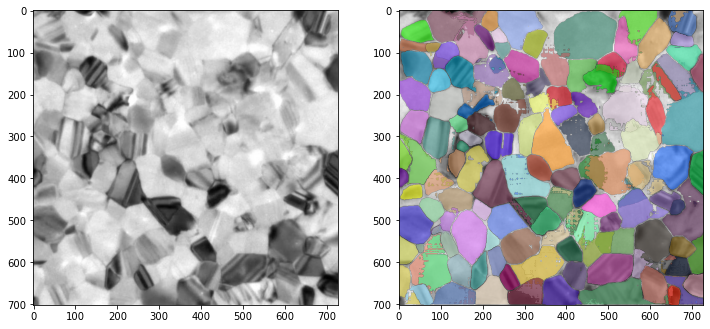

In [38]:
show_masks_on_image_2(img,mask_2d_with_neg)

In [184]:
ground_truth_masks.shape

(133, 702, 726)

In [185]:
mask_2d_with_neg.shape

(132, 702, 726)

100%|██████████| 133/133 [00:57<00:00,  2.32it/s]


0.7766999743651247


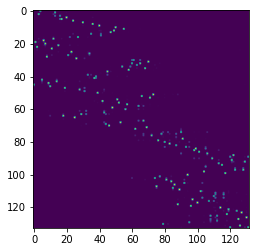

In [41]:
cm_2d_neg = cm_dce(ground_truth_masks,mask_2d_with_neg)
plt.imshow(cm_2d_neg)
mean_dice = np.average(np.max(cm_2d_neg,axis = 1))
print(mean_dice)

(array([ 3.,  2.,  0.,  2.,  4.,  6., 14., 26., 39., 37.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

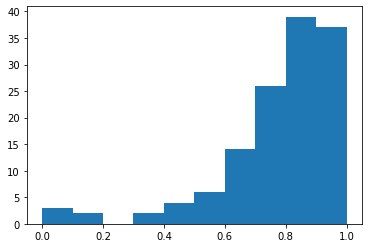

In [106]:
plt.hist(np.max(cm_2d_neg,axis = 1),bins = np.arange(0,1.1,0.1))

In [42]:
mask_2d_with_neg.shape

(132, 702, 726)

In [43]:
a,_,_ = mask_2d_with_neg.shape
mask_2d_neg_closed = np.zeros_like(mask_2d_with_neg)
for i in tqdm(range(a)):
    mask_2d_neg_closed[i] = get_mask_closed_filled(mask_2d_with_neg[i])

100%|██████████| 132/132 [00:17<00:00,  7.52it/s]


(132, 702, 726)


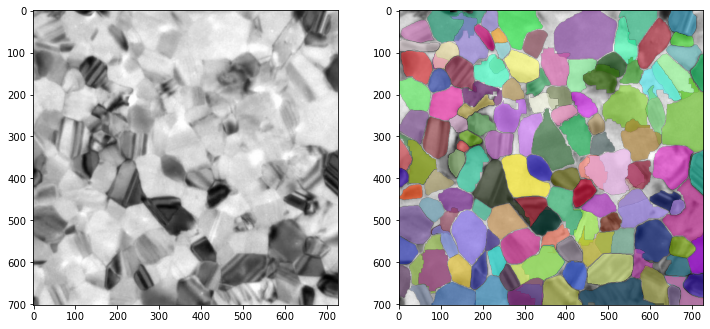

In [49]:
show_masks_on_image_2(img,mask_2d_neg_closed)

100%|██████████| 133/133 [00:33<00:00,  4.00it/s]


0.7825399698110097


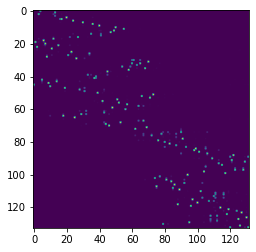

In [48]:
cm_2d_neg_closed = cm_dce(ground_truth_masks,mask_2d_neg_closed)
plt.imshow(cm_2d_neg_closed)
mean_dice = np.average(np.max(cm_2d_neg_closed,axis = 1))
print(mean_dice)

(array([ 3.,  2.,  1.,  1.,  4.,  5., 15., 20., 39., 43.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

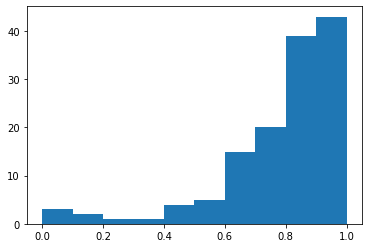

In [107]:
plt.hist(np.max(cm_2d_neg_closed,axis = 1),bins = np.arange(0,1.1,0.1))

In [51]:
#getting multiple images for concatenation

In [52]:
curr_di = os.getcwd()
img_fol = curr_di+"/crop_image"
gg = os.listdir(img_fol)
gg1 = [i for i in gg if (int(i.split('.')[0][7:])>=750 and int(i.split('.')[0][7:])<775)]

In [54]:
print(len(gg1))
print(img.size)
print(len(crop_900_pts_token))

25
(726, 702)
132


In [56]:
#check with Mode filter on the 3D without negative labels

# trying centroid based method
# after that applying the mode filter
num_of_images = len(gg1)
num_of_masks = len(crop_900_pts_token)
width,height = img.size

mask_3d = np.zeros((num_of_masks,num_of_images,height,width))

for i,fil_name in tqdm(enumerate(gg1)):
    
    img_file = img_fol+"/"+fil_name
    img  = Image.open(img_file).convert('RGB')
    
    input_points = [crop_900_pts_token]

    inputs = processor(img, input_points=input_points,return_tensors="pt").to(device)
    image_embeddings = model.get_image_embeddings(inputs["pixel_values"])

    inputs.pop("pixel_values", None)
    inputs.update({"image_embeddings": image_embeddings})

    with torch.no_grad():
        outputs = model(**inputs,multimask_output=False)

    masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
    #print(masks[0].shape)
    #break
    mask_3d[0:num_of_masks,i,:] = np.squeeze(masks[0].cpu().detach().numpy())

25it [00:37,  1.50s/it]


In [59]:
#filling these masks
a,b,_,_ = mask_3d.shape
mask_3d_closed = np.zeros_like(mask_3d)
for i in tqdm(range(a)):
    for j in range(b):
        mask_3d_closed[i][j] = get_mask_closed_filled(mask_3d[i][j])

100%|██████████| 132/132 [04:45<00:00,  2.16s/it]


In [62]:
masks_3d_closed_mode = np.zeros_like(mask_3d_closed[:,0:1,:,:])
for i,gg_mask in tqdm(enumerate(mask_3d_closed)):
    masks_3d_closed_mode[i] = stats.mode(gg_mask,axis = 0)[0]

132it [29:21, 13.35s/it]


(132, 702, 726)


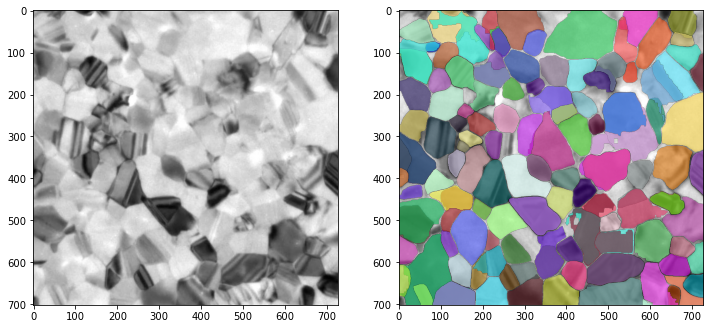

In [64]:
show_masks_on_image_2(img,masks_3d_closed_mode)

In [76]:
masks_3d_closed_mode = np.array(np.squeeze(masks_3d_closed_mode),np.uint8)

In [77]:
masks_3d_closed_mode.shape

(132, 702, 726)

In [78]:
ground_truth_masks.shape

(133, 702, 726)

100%|██████████| 133/133 [00:27<00:00,  4.86it/s]

0.7557848416112346


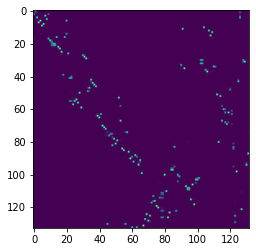

In [79]:
masks_3d_closed_mode = np.squeeze(masks_3d_closed_mode)
cm_3d_closed_mode = cm_dce(ground_truth_masks,masks_3d_closed_mode)
plt.imshow(cm_3d_closed_mode)
mean_dice = np.average(np.max(cm_3d_closed_mode,axis = 1))
print(mean_dice)

In [109]:
masks_3d_closed_mode.shape

(132, 702, 726)

(array([ 4.,  1.,  4.,  7.,  1.,  8., 14., 15., 33., 46.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

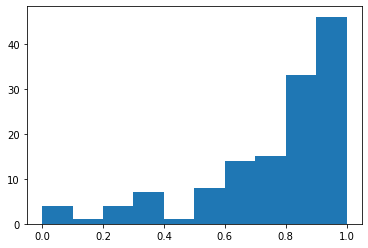

In [112]:
plt.hist(np.max(cm_3d_closed_mode,axis = 1),bins = np.arange(0,1.1,0.1))

In [ ]:
### Using Mode filter with negative labels.

In [81]:
num_of_images = len(gg1)
num_of_masks = len(crop_900_pts_token)
width,height = img.size

mask_3d_neg = np.zeros((num_of_masks,num_of_images,height,width))

for i,fil_name in tqdm(enumerate(gg1)):
    
    img_file = img_fol+"/"+fil_name
    img  = Image.open(img_file).convert('RGB')
    
    
    
    for j,pts,labels in zip([k for k in range(len(input_cents))],input_cents,cent_labels):
        
        input_points = [[pts]]
        input_labels = [[labels]]

        inputs = processor(img, input_points=input_points,input_labels = input_labels,return_tensors="pt").to(device)
        image_embeddings = model.get_image_embeddings(inputs["pixel_values"])

        inputs.pop("pixel_values", None)
        inputs.update({"image_embeddings": image_embeddings})

        with torch.no_grad():
            outputs = model(**inputs,multimask_output=False)

        masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
        mask_3d_neg[j,i,:] = np.squeeze(masks[0].cpu().detach().numpy())

25it [43:21, 104.06s/it]


In [82]:
#filling these masks
a,b,_,_ = mask_3d_neg.shape
mask_3d_neg_closed = np.zeros_like(mask_3d_neg)
for i in tqdm(range(a)):
    for j in range(b):
        mask_3d_neg_closed[i][j] = get_mask_closed_filled(mask_3d_neg[i][j])

100%|██████████| 132/132 [02:00<00:00,  1.09it/s]


In [83]:
masks_3d_neg_closed_mode = np.zeros_like(mask_3d_neg_closed[:,0:1,:,:])
for i,gg_mask in tqdm(enumerate(mask_3d_neg_closed)):
    masks_3d_neg_closed_mode[i] = stats.mode(gg_mask,axis = 0)[0]

132it [20:58,  9.54s/it]


(132, 702, 726)


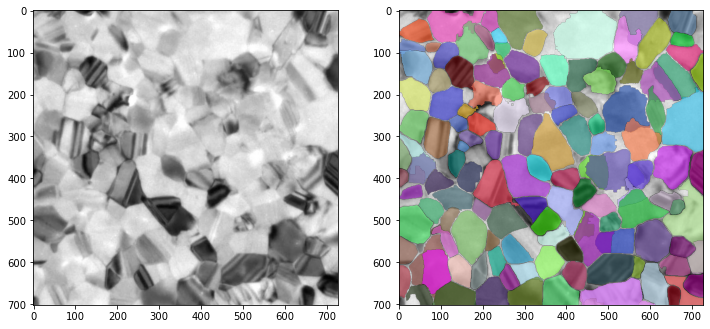

In [84]:
show_masks_on_image_2(img,masks_3d_neg_closed_mode)

100%|██████████| 133/133 [00:27<00:00,  4.76it/s]

0.7907219425954267


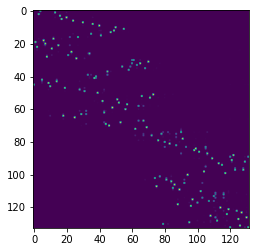

In [85]:
masks_3d_neg_closed_mode = np.array(np.squeeze(masks_3d_neg_closed_mode),np.uint8)
cm_3d_neg_closed_mode = cm_dce(ground_truth_masks,masks_3d_neg_closed_mode)
plt.imshow(cm_3d_neg_closed_mode)
mean_dice = np.average(np.max(cm_3d_neg_closed_mode,axis = 1))
print(mean_dice)

(array([ 3.,  1.,  1.,  4.,  1.,  4., 13., 22., 40., 44.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

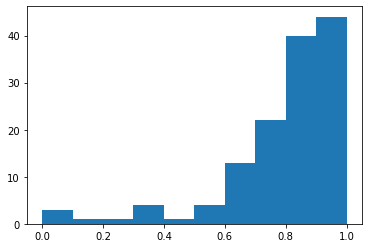

In [113]:
plt.hist(np.max(cm_3d_neg_closed_mode,axis = 1),bins = np.arange(0,1.1,0.1))